None


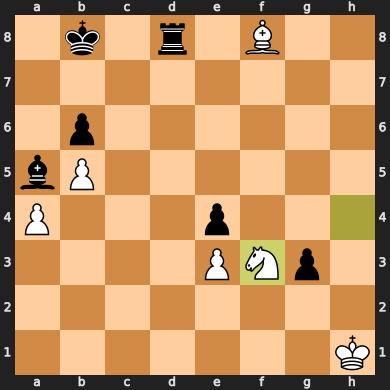

In [1]:
import chess
import chess.engine
import chess.svg

import time
import random
import os


def random_board(max_depth=200):
    board = chess.Board()
    depth = random.randrange(0, max_depth)

    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break
    return board

sf = chess.engine.SimpleEngine.popen_uci('stockfish-ubuntu-x86-64-avx2/stockfish/stockfish-ubuntu-x86-64-avx2')


def stockfish(board,depth):
  #Using the python chess library --> Import stockfish
  #Returns the score of white when playing
    global sf
    result = sf.analyse(board,chess.engine.Limit(depth=depth))
    score = result["score"]
    
    #Change to black and white accordingly --> Black for black to win , White for white to win
    return score.white().score()


def board_svg(board):
    #Displays and saves board as a svg file
    boardsvg = chess.svg.board(board, size=350)
    with open('temp.svg', 'w') as outputfile:
        outputfile.write(boardsvg)
    time.sleep(0.1)
    os.startfile('temp.svg')


board = random_board()

    
    #Stockfish evaluation prediction
    #Later on when creating training data --> we want this value to be at a mid-low depth like 3, 5, or 7
    #Depth is not an numerical representation of how many layers it goes down, but jsut a metric that tells you the strength of how deep to look
    #https://www.reddit.com/r/chess/comments/y5zfe5/what_actually_is_meant_by_the_depth_of_a_chess/
    
print(stockfish(board,10))
board




In [2]:
import numpy as np
import chess
import chess.engine
import re

squares_index = {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3,
    "e": 4,
    "f": 5,
    "g": 6,
    "h": 7
}

#Example => h3 = 5 7
def square_to_index(square):
  letter = chess.square_name(square)
  # return (row 1-8), col(a-h --> 1-8)
  return 8- int(letter[1]), squares_index[letter[0]]


#Note to self: 
#Consider recording the legal moves of each piece instead of all the legal moves all at once
#It will reduce the number of data to iterate through, and create a better representation of the chess board
 
#Used for Mark I, II models
def split_dims(board):
    """Convert FEN string to a 14x8x8 array representation."""    
    board3d = np.zeros((14, 8, 8), dtype=np.int8)
    
    # Layer mapping (piece type to array index)
    piece_map = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    
    # Get piece positions and populate the array
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_idx = piece_map[piece.symbol()]
            row, col = divmod(square, 8)
            board3d[piece_idx, 7 - row, col] = 1
    
    # Record legal moves for both sides
    aux = board.turn
    
    # Encode possible moves for white
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[12][i][j] = 1
    
    # Encode possible moves for black
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[13][i][j] = 1
    
    # Reset board back to original position
    board.turn = aux
    
    return board3d






In [3]:
import torch
PIECE_TO_INT_2 = {key: i for i, key in enumerate(["r", "n", "b", "q", "k", "p", "R", "N", "B", "Q", "K", "P"])}
TURN_TO_INT = {"w": 0, "b": 1}
def transform_fen(inp_fen:str) -> torch.Tensor:
    board_tensor = []
    for i, piece in enumerate(PIECE_TO_INT_2.keys()):
        piece_matrix = []
        for row in inp_fen.split("/"):
            row_vec = []
            assert isinstance(row, str)
            for element in row:
                if element.isalpha():
                    if element == piece:
                        row_vec += [1]  
                    else:
                        # it's a piece but not the one on the loop
                        row_vec += [0]
                else:
                    if element.isdigit():
                        row_vec += int(element) * [0]  # add as many zeros as the number
                    else:
                        raise ValueError  # raise error if that element is not an integer or a string
            assert len(row_vec) == 8
            piece_matrix.append(row_vec)
        assert len(piece_matrix) == 8
        board_tensor.append(piece_matrix)
    assert len(board_tensor) == 12
    return torch.ByteTensor(board_tensor)


CASTLE_TO_INT = {key: i for i, key in enumerate(["K", "Q", "k", "q"])}
def castle_to_vec(inp_castle_str):
    out_vec = 4 * [0]
    if inp_castle_str != "-":
        for side in inp_castle_str:
            out_vec[CASTLE_TO_INT[side]] = 1
    return torch.ByteTensor(out_vec)


ENPASSANT_TO_INT = {key: str(i + 1) for i, key in enumerate(["a", "b", "c", "d", "e", "f", "g", "h"])}

def en_passant_to_vec(inp_en_passant):
    output_tensor = torch.zeros([8, 8], dtype=torch.uint8)
    if inp_en_passant != "-":
        assert len(inp_en_passant) == 2
        assert inp_en_passant[0].isalpha()
        assert inp_en_passant[1].isdigit()
        square = (int(ENPASSANT_TO_INT[inp_en_passant[0]])-1, int(inp_en_passant[1])-1)
        assert isinstance(square, tuple)
        output_tensor[7-square[1],square[0]] = 1
    return output_tensor

def encode_fen_flat(inp_fen_string):
    board_str, turn_str, castling_str, enpassant_str, _, _ = inp_fen_string.split(" ")
    board_tensor = transform_fen(board_str).type(torch.FloatTensor)
    assert board_tensor.size() == torch.Size([12, 8, 8])
    enpassant_tensor = en_passant_to_vec(enpassant_str).type(torch.FloatTensor)
    assert enpassant_tensor.size() == torch.Size([8,8])
    castling_tensor = castle_to_vec(castling_str).type(torch.FloatTensor)
    assert castling_tensor.size() == torch.Size([4])
    turn_tensor = torch.ByteTensor([TURN_TO_INT[turn_str]]).type(torch.FloatTensor)
    assert turn_tensor.size() == torch.Size([1])
    
    # Concatenate vectors for Feed-forward network stacking all values in a single dimension
    output_tensor = torch.cat((board_tensor.flatten(), enpassant_tensor.flatten(),castling_tensor.flatten(),turn_tensor.flatten()), 0)
    
    return output_tensor     

In [4]:
encode_fen_flat("8/p7/1prn2k1/3r1pp1/PR1Pp3/2P3P1/2KN1P2/4R3 b - - 5 42")

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [5]:
from torch.nn.init import xavier_uniform_
device = torch.device("cpu")

def init_weights(m):
    try:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    except Exception:
        return
    
class MLP(torch.nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()    
        self.base_model = torch.nn.Sequential(
        torch.nn.Linear(n_inputs, 600),
        torch.nn.ReLU(),
        torch.nn.Dropout(.2),
        torch.nn.Linear(600, 300),
        torch.nn.Dropout(.2),
        torch.nn.ReLU(),
        torch.nn.Linear(300, 100),
        torch.nn.Dropout(.2),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1),
    ).to(device)
        self.base_model.apply(init_weights)

    # forward propagate input
    def forward(self, X):
        X = X.to(device)
        # input to first hidden layer
        X = self.base_model(X)
        return X

markIII = torch.load('model.pt',map_location=torch.device('cpu'))


C:\Users\benja\AppData\Local\Temp\ipykernel_14824\2966923511.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mark = torch.load('model.pt',map_location=torch.device('cpu

In [6]:
USE_ARCTAN = True

import chess

examples = ["r1bqk1nr/pp1pppbp/2n3p1/1Bp5/4P3/5N2/PPPP1PPP/RNBQ1RK1 w Qkq - 0 1",
            "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/R1BQKBNR w KQkq - 0 1",
           "r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 1",
            "8/8/1q1k4/8/8/3K4/8/8 w - - 0 1",
            "8/5r2/3k4/8/8/3K4/8/8 w - - 0 1",
           "r1bqkbnr/1ppp1ppp/p1n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 0 1",
           "4k3/8/8/8/8/8/PPPPPPPP/RNBQKBNR w KQ - 0 1",
           "8/8/8/4k3/8/8/4K3/2Q5 w - - 0 1"]


def predict(fen_reps, model):
    
    features = []
    for fen_rep in fen_reps:
        features.append(encode_fen_flat(fen_rep))
    
    features = torch.stack(
    features
    ,dim=0
    )
    # make predictions
    model.eval()
    with torch.no_grad():
        yhats = model(features)
    # retrieve numpy array
    yhats = yhats.to('cpu').detach().numpy()
    if USE_ARCTAN:
        yhats = np.tan(yhats)
    for yh, fen in zip(yhats, fen_reps):
        print(f"Model evaluation {yh}")

In [7]:
predict(fen_reps=examples,model=markIII)

Model evaluation [0.53723145]
Model evaluation [0.6764705]
Model evaluation [0.70873666]
Model evaluation [-0.4362836]
Model evaluation [-0.901536]
Model evaluation [0.44179243]
Model evaluation [2.1864212]
Model evaluation [0.02434193]


In [ ]:
#Just a Quick note because I made the code janky as hell

#1. Edit the names of the evaluation functions (stockfish_eval , minimax_eval_12, minimax_eval_3)
#2. Edit the names of the minimax algorithm (within code too)
#3. Edit the names of get AI move

#Eventually, I will need to fix this. Bear with me ;_;

#The data preprocessing for Mark I,II / Mark III are different. Hence, Complications are created

In [18]:
#Stockfish Minimax

import numpy as np
import tensorflow as tf

def stockfish_eval(board):
  return stockfish(board,10)
  


def minimax_sf(board, depth, alpha, beta, maximizing_player):
  if depth ==0 or board.is_game_over():
    return stockfish_eval(board)
    

  if maximizing_player:
    max_eval = -np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax_sf(board,depth-1,alpha,beta,False)
      board.pop()
      max_eval = max(max_eval,eval)
      alpha = max(alpha,eval)
      if beta <= alpha:
        break
    return max_eval

  else:
    min_eval = np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax_sf(board,depth-1,alpha,beta,True)
      board.pop()
      min_eval = min(min_eval,eval)
      beta = min(beta,eval)
      if beta <= alpha:
        break
    return max_eval


def get_ai_move_sf(board,depth):
  max_move = None
  max_eval = -np.inf
  for move in board.legal_moves:
    board.push(move)
    eval = minimax_sf(board,depth-1,-np.inf,np.inf,False)
    board.pop()
    if(eval != None) and (eval > max_eval):
      max_eval = eval
      max_move = move
  return max_move

In [88]:
#Minimax Predictions (Compatible with models 1,2)
def minimax_eval_12(board,model):
    board3d = split_dims(board)
    board3d = np.expand_dims(board3d, axis=0)  # Shape (1, 14, 8, 8)
    return model.predict(board3d,verbose=0)[0][0]

def minimax_eval_3(board,model):
    fen = str(board.fen())
    features = torch.Tensor(
    encode_fen_flat(fen)
    )
    # make predictions
    model.eval()
    with torch.no_grad():
        yhats = model(features)
    # retrieve numpy array
    yhats = yhats.to('cpu').detach().numpy()
    if USE_ARCTAN:
        yhats = np.tan(yhats)
    return yhats
    

In [20]:
#Mark I Minimax
model_1 = tf.keras.models.load_model('Mark I.keras')

def minimax_1(board, depth, alpha, beta, maximizing_player):
    global model_1
    if depth == 0 or board.is_game_over():
        # Change this to minimax_eval(board, model) to make it work for trained model
        #return stockfish_eval(board)
        return minimax_eval_12(board, model_1)

    if maximizing_player:
        max_eval = -np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_1(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval

    else:
        min_eval = np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_1(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval  # Corrected to return min_eval instead of max_eval
    
def get_ai_move_1(board,depth):
  max_move = None
  max_eval = -np.inf
  for move in board.legal_moves:
    board.push(move)
    eval = minimax_1(board,depth-1,-np.inf,np.inf,False)
    board.pop()
    if(eval != None) and (eval > max_eval):
      max_eval = eval
      max_move = move
  return max_move


In [52]:
#Mark II Minimax
model_2 = tf.keras.models.load_model('Mark II.keras')

def minimax_2(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        global model_2
        # Change this to minimax_eval(board, model) to make it work for trained model
        #return stockfish_eval(board)
        
        return minimax_eval_12(board, model_2)

    if maximizing_player:
        max_eval = -np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_2(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval

    else:
        min_eval = np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_2(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval  # Corrected to return min_eval instead of max_eval
    
def get_ai_move_2(board,depth):
  max_move = None
  max_eval = -np.inf
  for move in board.legal_moves:
    board.push(move)
    eval = minimax_2(board,depth-1,-np.inf,np.inf,False)
    board.pop()
    if(eval != None) and (eval > max_eval):
      max_eval = eval
      max_move = move
  return max_move


In [89]:
#Mark III Minimax
model_3 = torch.load('model.pt',map_location=torch.device('cpu'))


def minimax_3(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        global model_3
        # Change this to minimax_eval(board, model) to make it work for trained model
        #return stockfish_eval(board)
        
        return minimax_eval_3(board, model_3)

    if maximizing_player:
        max_eval = -np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_3(board, depth - 1, alpha, beta, False)
           
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval

    else:
        min_eval = np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_3(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval  # Corrected to return min_eval instead of max_eval
    
def get_ai_move_3(board,depth):
  max_move = None
  max_eval = -np.inf
  for move in board.legal_moves:
    board.push(move)
    eval = minimax_3(board,depth-1,-np.inf,np.inf,False)
    board.pop()
    if(eval != None) and (eval > max_eval):
      max_eval = eval
      max_move = move
  return max_move


C:\Users\benja\AppData\Local\Temp\ipykernel_14824\1975091727.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3 = torch.load('model.pt',map_location=torch.device('c

a3a4


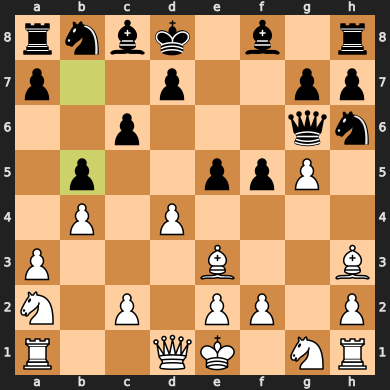

In [23]:
board = random_board()
print(get_ai_move_1(board,1))
board

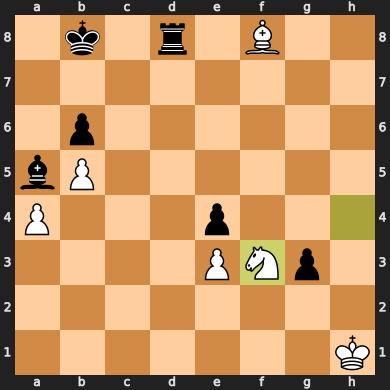

In [5]:
board

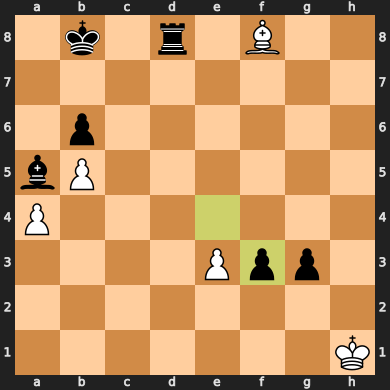

In [6]:
board.push_uci("e4f3")
board

In [7]:
list(board.legal_moves)

[Move.from_uci('f8g7'),
 Move.from_uci('f8e7'),
 Move.from_uci('f8h6'),
 Move.from_uci('f8d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8b4'),
 Move.from_uci('f8a3'),
 Move.from_uci('h1g1'),
 Move.from_uci('e3e4')]

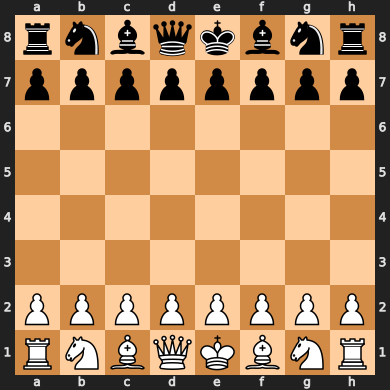

In [90]:
#Reset the board
board = chess.Board()
board


In [ ]:
#Our Move
board.push_uci("e1e2")
board

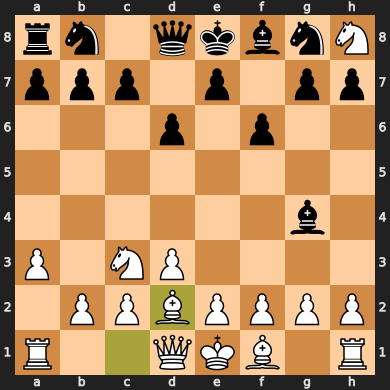

In [105]:
bot_1 = str(get_ai_move_2(board,1))
board.push_uci(bot_1)
board

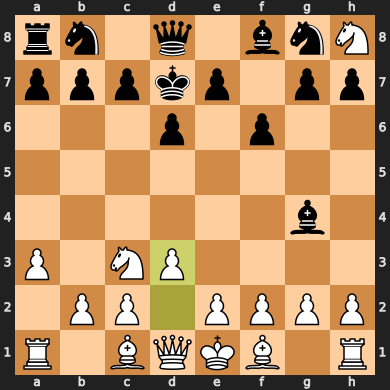

In [103]:
#AI Move
big_brain_ai = str(get_ai_move_3(board,1))
board.push_uci(big_brain_ai)
board

In [ ]:
while (not board.is_game_over()):
    bot_1 = str(get_ai_move_1(board,1))
    board.push_uci(bot_1)
    board

    big_brain_ai = str(get_ai_move_2(board,1))
    board.push_uci(big_brain_ai)
    board
board

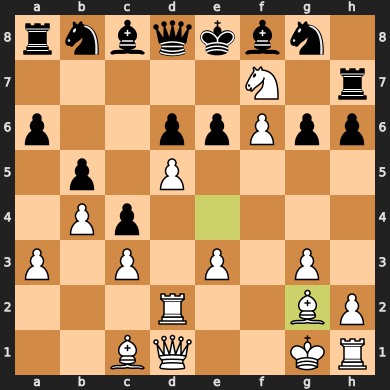

In [41]:
board

In [84]:
examples = ["r1bqk1nr/pp1pppbp/2n3p1/1Bp5/4P3/5N2/PPPP1PPP/RNBQ1RK1 w Qkq - 0 1",
            "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/R1BQKBNR w KQkq - 0 1",
           "r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 1",
            "8/8/1q1k4/8/8/3K4/8/8 w - - 0 1",
            "8/5r2/3k4/8/8/3K4/8/8 w - - 0 1",
           "r1bqkbnr/1ppp1ppp/p1n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 0 1",
           "4k3/8/8/8/8/8/PPPPPPPP/RNBQKBNR w KQ - 0 1",
           "8/8/8/4k3/8/8/4K3/2Q5 w - - 0 1"]
board = chess.Board(examples[0])
print(stockfish_eval(board))


model_3 = torch.load('model.pt',map_location=torch.device('cpu'))
def predict(fen, model):
    
    features = torch.Tensor(
    encode_fen_flat(fen)
    )
    # make predictions
    model.eval()
    with torch.no_grad():
        yhats = model(features)
    # retrieve numpy array
    yhats = yhats.to('cpu').detach().numpy()
    if USE_ARCTAN:
        yhats = np.tan(yhats)
    return yhats
    
predict(examples[0],model_3)

19
Model evaluation [0.5372315]


C:\Users\benja\AppData\Local\Temp\ipykernel_14824\1331173876.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3 = torch.load('model.pt',map_location=torch.device('

array([0.5372315], dtype=float32)

In [86]:
board.fen()

'r1bqk1nr/pp1pppbp/2n3p1/1Bp5/4P3/5N2/PPPP1PPP/RNBQ1RK1 w kq - 0 1'

In [ ]:
Model evaluation [0.53723145]
Model evaluation [0.6764705]
Model evaluation [0.70873666]
Model evaluation [-0.4362836]
Model evaluation [-0.901536]
Model evaluation [0.44179243]
Model evaluation [2.1864212]
Model evaluation [0.02434193]